# Laboratorio 8 (Segmentación de Clientes de Banco) - Inteligencia Artificial
Autores: Stefano Aragoni, Carol Arévalo, Luis Santos

_________

En este caso, se tiene un dataset en el cual se desea analizar la segmentación de clientes de un banco. Es dataset provisto contiene información de diferentes trasacciones realizadas por clientes. Del cliente, tenemos información como su fecha de nacimiento, género, ubicación, dinero actual en su cuenta, así como la cantidad de dinero involucrada en la respectiva transacción.

A continuación se presenta cómo se utilizó Mixed Model para poder hacer la agrupación de clientes según diferentes características provistas por el dataset.

_____________

### Task 1.0: Exploración y Limpieza de Datos
Como primer paso, se importa el archivo a través de distintas librerías. 

In [33]:
# Importar librerías 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import numpy as np

# Cargar el dataset
data = pd.read_csv('bank_transactions.csv')

data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


##### Datos Faltantes
En este caso, se encontró que CustomerDOB contaba con datos faltantes. Por tal razón, posteriormente se utilizó un método para poder rellenar dichos datos faltantes.

Index(['CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance'], dtype='object')

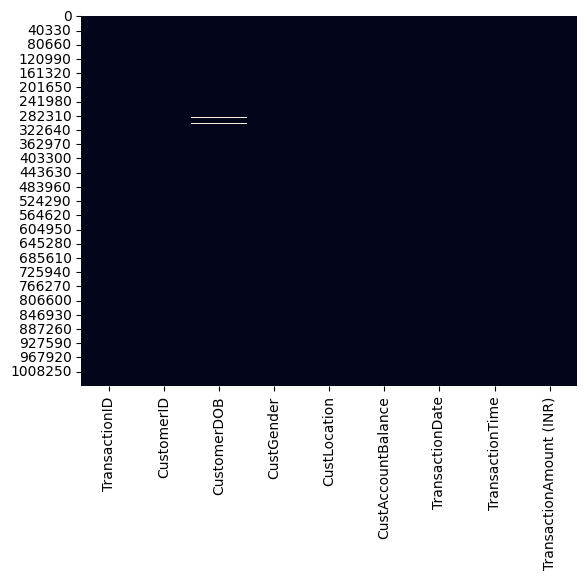

In [2]:
# Matriz de datos faltantes
sns.heatmap(data.isnull(), cbar=False)

# Mostrar columnas con datos faltantes, o con datos fuera de lugar (como un string en columna numérica)
data.columns[data.isnull().any()]

En caso hayan datos faltantes que no se pueden observar en la gráfica, a continuación se realizó un proceso que rellena datos faltantes con promedio de datos.

In [3]:
for col in data.columns[data.isnull().any()]:

    if data[col].dtype == 'float64' or data[col].dtype == 'int64':
        data[col].fillna(data[col].mean(), inplace=True)

    else:
        data[col].fillna(data[col].mode()[0], inplace=True)

data.columns[data.isnull().any()]

Index([], dtype='object')

In [4]:
data_copy = data.copy()

In [5]:
data = data_copy.copy()

##### Encoding
Convertir variables que no son numéricas a numéricas. En este caso, principalmente se estaba conviertiendo fecha de nacimiento a edad. Se mapeó género a 0 o 1, correspondiente a M y F. Por otro lado, se eliminaron variables de ID, ya que no presentan información útil para la clasificación de clientes; solo son identificadores únicos.

In [6]:
import datetime
from datetime import timedelta, date
from sklearn.preprocessing import LabelEncoder

#-------------------EDAD-------------------------
# Convertir CustomerDOB a año de nacimiento
data['YOB'] = '19' + data['CustomerDOB'].str[-2:]
data['YOB'] = data['YOB'].astype(int)

# Eliminar columna de DOB
data = data.drop(['CustomerDOB'], axis=1)

# Determinar edad
data['Age'] = 2023 - data['YOB']

# Eliminar columna de YOB
data = data.drop(['YOB'], axis=1)

#-------------------GENERO-------------------------
# Convertir genero a int. M = 0, F = 1
data['CustGender'] = data['CustGender'].map({'M': 0, 'F': 1})

#------------ELIMINAR TRANSACTIONS----------------
data = data.drop(['TransactionID'], axis=1)

#----------ELIMINAR VARIABLES QUE NO DAN INFO DE CLIENTE --------------
data = data.drop(['TransactionDate'], axis=1)

#-----------------ELIMINAR CID--------------------
# promediar CustAccountBalance y TransactionAmount de los mismos clientes y dejar una columna por cliente
data = data.groupby(['CustomerID']).mean()

data.head()

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_11057/827789144.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['CustomerID']).mean()


,CustGender,CustAccountBalance,TransactionTime,TransactionAmount (INR),Age
CustomerID,,,,,
C1010011,0.5,76340.635,67521.0,2553.0,35.5
C1010012,0.0,24204.490,204409.0,1499.0,29.0
C1010014,0.5,100112.950,187378.0,727.5,35.0
C1010018,1.0,496.180,170254.0,30.0,33.0
C1010024,0.0,87058.650,141103.0,5000.0,58.0


In [7]:
# Pasar data a formato de matriz sin CustomerID
custGender = data['CustGender'].values
custAge = data['Age'].values
custAccountBalance = data['CustAccountBalance'].values
transactionAmount = data['TransactionAmount (INR)'].values
transactionType = data['TransactionTime'].values

# combinar en dataset de pandas
data = pd.DataFrame({'CustGender': custGender, 'Age': custAge, 'CustAccountBalance': custAccountBalance, 'TransactionAmount (INR)': transactionAmount, 'TransactionTime': transactionType})

# eliminar donde CustGender no es igual a 0 o 1
data = data[(data['CustGender'] == 0) | (data['CustGender'] == 1)]

print(data.head())

   CustGender   Age  CustAccountBalance  TransactionAmount (INR)  \
1         0.0  29.0           24204.490                   1499.0   
3         1.0  33.0             496.180                     30.0   
4         0.0  58.0           87058.650                   5000.0   
5         1.0  35.0          296828.370                    557.0   
6         0.0  37.0            5200.155                    932.0   

   TransactionTime  
1         204409.0  
3         170254.0  
4         141103.0  
5          95212.0  
6         162771.5  


##### Balanceo
En este caso se determinó que no es necesario balancear los datos debido a que es un modelo no supervisado, por lo cual no se requiere. 

##### Escalar
En este caso, se utilizó la librería de SKLearn para poder escalar y normalizar los datos que lo necesitaran. Asimismo, también se hizo un análisis pre y post escalamiento para determinar la distribución de los datos. En el preprocesamiento, se podía observar cómo ciertas variables tenían una alta desviación estándar a comparación de su respectiva media. Esto fue solucionado a través de la función de MinMaxScaler(). 

> Asimismo, es importante mencionar que la normalización de datos es importante para, según Microsoft, "tener datos que usan una escala común, sin distorsionar las diferencias en los intervalos de valores ni perder información". https://learn.microsoft.com/es-es/azure/machine-learning/component-reference/normalize-data

In [8]:
data2 = data.copy()

In [9]:
# Calcular media y desviación estándar de cada columna
print('\n\nMedia y desviación estándar de cada columna:')
data2.describe()



Media y desviación estándar de cada columna:


,CustGender,Age,CustAccountBalance,TransactionAmount (INR),TransactionTime
count,824283.000000,824283.000000,8.242830e+05,8.242830e+05,824283.000000
mean,0.253167,43.107096,1.152263e+05,1.573144e+03,157055.751088
std,0.434826,21.180864,8.151974e+05,6.591278e+03,49957.649919
min,0.000000,24.000000,0.000000e+00,0.000000e+00,0.000000
25%,0.000000,33.000000,5.243320e+03,1.800000e+02,124803.000000
50%,0.000000,36.500000,1.793333e+04,4.877150e+02,163732.000000
75%,1.000000,43.000000,6.048961e+04,1.217390e+03,195244.000000
max,1.000000,123.000000,1.150355e+08,1.560035e+06,235959.000000


In [10]:
from sklearn.preprocessing import StandardScaler, normalize

data3 = data2.drop(['CustGender'], axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data3)
normalized_df = normalize(scaled_features) 

df_feat = pd.DataFrame(normalized_df, columns=data3.columns)
df_feat['CustGender'] = data2['CustGender'].values
print(df_feat.head())

        Age  CustAccountBalance  TransactionAmount (INR)  TransactionTime  \
0 -0.572244           -0.095933                -0.009665         0.814395   
1 -0.782246           -0.230715                -0.383793         0.433087   
2  0.754764           -0.037091                 0.558087        -0.342775   
3 -0.289142            0.168286                -0.116460        -0.935154   
4 -0.819125           -0.383435                -0.276341         0.325035   

   CustGender  
0         0.0  
1         1.0  
2         0.0  
3         1.0  
4         0.0  


##### Selección de Variables

Finalmente, se quiso determinar los 2 features que se estarían utilizando para la realización del modelo de agrupación. En este caso, se utilizó PCA para poder determinar qué 2 variables son las más significativas para los modelos a realizar. 

En este caso, se seleccionó transaction time junto con age.

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(df_feat) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 

# determinar cuales variables fueron seleccionadas por PCA
selected_variables = []
for component in pca.components_:
    max_index = np.argmax(np.abs(component))
    selected_variables.append(df_feat.columns[max_index])
    
print(selected_variables)

['TransactionTime', 'Age']


_______________
### Mixture Models
> 1. Si considera necesario haga split del dataset como en los laboratorios anteriores. Recuerde que es un problema de aprendizaje no supervisado

En este caso, no se hizo split del dataset ya que no se tiene un problema de aprendizaje supervisado. Es decir, que no se está comprobando que el modelo realizado sepa clasificar datos. Simplemente se quiere crear agrupaciones de los clientes del banco.

> 2. Seleccione el número de clusters que mejor se adapte al dataset. Justifique su elección

Se utilizó la Gráfica de "Elbow" en ambos casos (Mixed Model manual y de SKLearn) para determinar el punto donde se estabiliza el Negative Log Likelihood (o NLL). Este punto donde se estabiliza dicho valor es conocido como el "codo" de una gráfica. A través de este procedimiento, en ambos casos, se determinó que la mejor cantidad de número de clusters era 4. Como resultado, se envió este parámetro con los modelos.

> 3. ¿Podría PCA ayudarle a mejorar la calidad de sus clusters?

Principal Component Analysis es una técnica que permite analizar datasets muy grandes y reducir su dimensionalidad. Esto se logra transformando la información a un sistema lineal de cordenadas que describe la mayor cantidad posible de la información original. Dicho procedimiento resulta en que se reduzca el ruido así como la complejidad de los datos; esto a través de eliminar features reduntantes o que no se correlacionan mucho.

PCA sí puede ayudar a mejorar la cantidad de nuestros clusters disminuyendo la cantidad de features que se encuentran en el dataset y que producen ruido, sin perder información importante para este. Esto especialmente considerando la gran cantidad de features que contiene el respectivo dataset. 

En realdiad, se utilizó PCA para poder determinar que las features más importantes para poder clusterizar son age y transaction time. 

> 4. Muestre al menos una gráfica que muestre cómo se dividen los clusters seleccionados. Seleccione dos features, justifique su elección

En este caso se crearon 2 gráficas, una para Mixed Model manual y otra para SKLearn. En ambos casos, se puede observar que se dividen los datos y cómo se crearon los respectivos clusters. Cabe destacar que los resultados no son identicos, posiblemente debido a las diferencias de implementación del algoritmo en algunos aspectos. 

En ambos casos se graficó las variables Age y Transaction Time. Inicialmente, se había realizado el modelo con dos variables diferentes que habían sido escogido según su nivel de correlación entre sí (justo como se realizó en el Lab 7). Sin embargo, estas variables no presentaban los datos de manera óptima para señalizar las agrupaciones. Por tal razón, se optó por buscar otra manera para buscar las mejores variables. 

A través de PCA se logró determinar las variables de Age y Transaction Time, lo cual permitió poder utilizar el modelo de Gaussian Mixed Model para poder graficar los respectivos grupos. En este caso, como se puede observar a continuación, sí se logró determinar los clusters y se logró graficar los elipses de covarianza. 

> 5. Provea una métrica de desempeño, justificando su elección

Para seleccionar la cantidad de clusters, se utilizó le métrica de NLL y se graficaron los valores de WSS de diferentes modelos con distintos valores de clusters. Este valor indica el Negative Log Likelihood del modelo, y se buscaba encontrar aquel número de clusters que en la gráfica representara el codo de la misma. 

Por otro lado, decidió utilizar el índice de Davies–Bouldin para analizar el rendimiento de cada modelo. Esto ya que este permite calificar que tan bien se dividieron los clusters de los algoritmos. Este índice indica el promedio de la relación máxima entre la distancia de un punto al centro de su grupo y la distancia entre dos centros de grupos. Un índice bajo indica una buena partición.

En este caso, cabe destacar que con SKLearn se logró obtener un mejor resultado. Esto ya que se obtuvo un índice de 0.74 mientras que con el algoritmo manual se obtuvo 0.87 (ambos modelos usaron 4 clusters). Como se mencionó anteriormente, mientras más bajo el índice, mejor. 
 
 > 6. Compare sus resultados con los que obtuvo en el laboratorio 7 ¿Cuál es mejor? ¿Por qué?

En el laboratorio 7, como se mencionó anteriormente, se seleccionaron diferentes variables y se tuvo una cantidad distinta de clusters (Age y Customer Account Balance) (3 en ambos modelos de K-Means). Debido a la teoría de Gaussian Mixed Model, las variables anteriormente seleccionadas no eran aptas para este modelo debido a que los datos no estaban agrupados en distribuciones. Por tal razón, el Mixed Model hacía agrupaciones raras que visualmente no tenían sentido. Como resultado, se tuvo que determinar otras variables a utilizar para el modelo de Gaussian Mixed Model. 

Por tal razón, creo que no podemos decir cuál es mejor o cuál es peor. Esto debido a que ambos modelos analizaron aspectos y variables diferentes, incluyendo parámetros distintos. Sin embargo, si nos basamos únicamente con la métrica de Davies Bouldin Index, el modelo de K-Means presentó un mejor resultado. Esto debido a que ambos modelos de K-Means presentaron un índice de 0.42 y 0.44, mientras que Mixed Model presentó 0.74 y 0.87. Como se mencionó anteriormente, esta métrica permite calificar qué tan bien se dividieron los clusters; por lo que un valor menor indica una mejor separación. 

> 7. Considerando sus resultados del laboratorio 7, ¿cuándo cree que es mejor usar Mixture Models y K-Means?

Como se mencionó anteriormente, es mejor utilizar K-Means cuando al graficar las variables (sin clasificación) uno puede determinar a simple vista posibles agrupaciones. Esto debido a que el modelo de K-Means es bueno para generar agrupaciones donde patrones son más visibles y sencillos. Sin embargo, Mixture Models es más útil cuando existen patrones escondidos dentro de un conjunto muy grande de datos. Estos patrones son posibles de encontrar a través de agrupar los datos en distribuciones de probabilidades, como la gaussiana. 

Es por esta misma razón que se tuvo que utilizar features diferentes para ambos modelos, ya que ambos modelos son útiles para situaciones distintas. 

_______________
### Task 1.1: Implementacion de Mixture Models

In [12]:
import numpy as np
from scipy.stats import norm
import numpy as np
from scipy.stats import multivariate_normal

def gaussian_mixture_model(X, n_components, n_iterations=10, tolerance=0.001):
    n_samples, n_features = X.shape

    # Initialize means, covariances, and weights
    means = np.random.randn(n_components, n_features)
    covariances = [np.eye(n_features) for _ in range(n_components)]
    weights = np.ones(n_components) / n_components

    prev_log_likelihood = 0

    for i in range(n_iterations):
        
        # E-step
        likelihoods = np.zeros((n_samples, n_components))
        for j in range(n_components):
            likelihoods[:, j] = weights[j] * multivariate_normal.pdf(X, means[j], covariances[j])
        responsibilities = likelihoods / np.sum(likelihoods, axis=1, keepdims=True)

        # M-step
        total_responsibilities = np.sum(responsibilities, axis=0)
        weights = total_responsibilities / n_samples
        means = np.dot(responsibilities.T, X) / total_responsibilities[:, np.newaxis]
        for j in range(n_components):
            diff = X - means[j]
            covariances[j] = np.dot(responsibilities[:, j] * diff.T, diff) / total_responsibilities[j]

        # Check convergence
        log_likelihood = np.sum(np.log(np.sum(likelihoods, axis=1)))
        if i > 0 and np.abs(log_likelihood - prev_log_likelihood) < tolerance:
            break
        prev_log_likelihood = log_likelihood

    # Calculate responsibilities
    likelihoods = np.zeros((n_samples, n_components))
    for j in range(n_components):
        likelihoods[:, j] = weights[j] * multivariate_normal.pdf(X, means[j], covariances[j])
    responsibilities = likelihoods / np.sum(likelihoods, axis=1, keepdims=True)

    avg_log_likelihood = prev_log_likelihood / n_samples

    # Assign data points to clusters
    clusters = np.argmax(responsibilities, axis=1)

    return means, covariances, weights, clusters, avg_log_likelihood

Posteriormente, se calculó el mejor valor de clusters a través de una gráfica de codo generada con la métrica de NLL. Como se puede observar en la gráfica siguiente, el mejor valor es clusters=4. 

k: 1 NLL: 1.8918423956945871
k: 2 NLL: 1.6876663424754013
k: 3 NLL: 1.2950009370401139
k: 4 NLL: 0.959618873654483
k: 5 NLL: 0.9626673593826762
k: 6 NLL: 0.7288152352442799
k: 7 NLL: 0.8027351894984999
k: 8 NLL: 0.6770972893341959


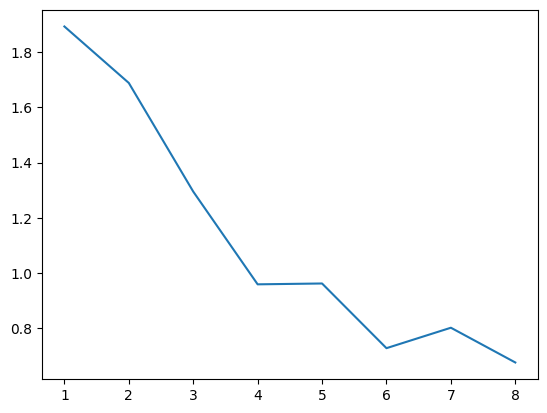

In [34]:
def calculate_NLL(X, kmax=10):
    nll = []
    for k in range(1, kmax+1):
        means, covariances, weights, clusters, avg_log_likelihood = gaussian_mixture_model(X_principal, n_components=k)
        curr_nll = -avg_log_likelihood
        print("k:", k, "NLL:", curr_nll)
        nll.append(curr_nll)
    return nll

# randomie X_principal
X_principal = X_principal.sample(frac=1).reset_index(drop=True)

nll = calculate_NLL(X_principal, kmax=8)

import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

x_plot = list(range(1, 9))
ax.plot(x_plot, nll)

In [48]:
means, covariances, weights, clusters, log_likelihood = gaussian_mixture_model(X_principal, n_components=4)

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_11057/20019895.py:24: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(pos, nsig * width, nsig * height, angle)


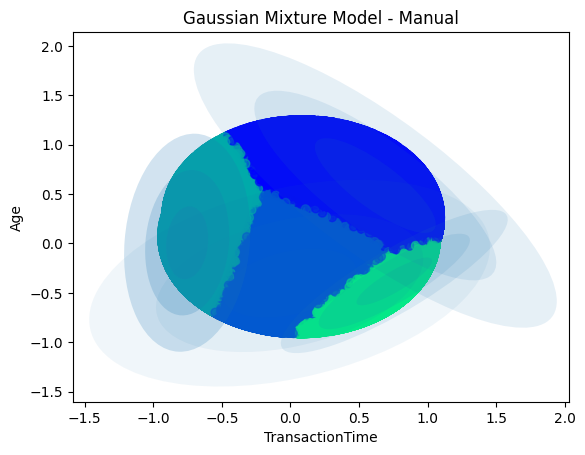

In [50]:
plt.scatter(X_principal['P1'], X_principal['P2'], c = clusters, cmap =plt.cm.winter, alpha = 0.6) 

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

w_factor = 0.2 / max(weights)

for pos, covar, w in zip(means, covariances, weights):
    w2 = w * w_factor

    # Convert covariance to principal axes
    if covar.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covar)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covar)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ellipse = Ellipse(pos, nsig * width, nsig * height, angle)
        ellipse.set_alpha(w2)
        plt.gca().add_patch(ellipse)

plt.xlabel('TransactionTime')
plt.ylabel('Age')
plt.title('Gaussian Mixture Model - Manual')
plt.show()

En este caso, la métrica de Davis Bouldin Index indica qué tan bien se crearon los clusters del respectivo modelo. Mientras más cercano a 0 esté el valor, mejor. En este caso se obtuvo 0.87. 

Esto es bueno, ya que mientras más bajo es este valor, mejor es la separación entre los clusters. Cabe destacar que el valor máximo promedio de este índice es 3 a 4 (pero podría llegar hasta el infinito positivo).

In [49]:
# Davis Bouldin Index
print("Davis Bouldin Index:", metrics.davies_bouldin_score(X_principal, clusters))

Davis Bouldin Index: 0.8727879110030887


__________________
### Task 1.2: Implementacion de Mixture Models con libreria

Como primer paso, se utilizó la métrica de NLL (Negative Log-Likelihood) score (que viene integrada con el modelo de gaussian mixture) para determinar los mejores hiperparámetros para el modelo. En este caso, el hiperparámetro que se estaba tunneando era número de clusters. 

En este caso, como se puede observar a continuación, se determinó que el mejor número de clusters sería 4. 

k: 1 NLL: 1.891842395698786
k: 2 NLL: 1.3382928815271324
k: 3 NLL: 1.0957615887387924
k: 4 NLL: 0.7689996191606632
k: 5 NLL: 0.6639452854618382
k: 6 NLL: 0.6305924822529991
k: 7 NLL: 0.5595156816705829
k: 8 NLL: 0.513769439071339


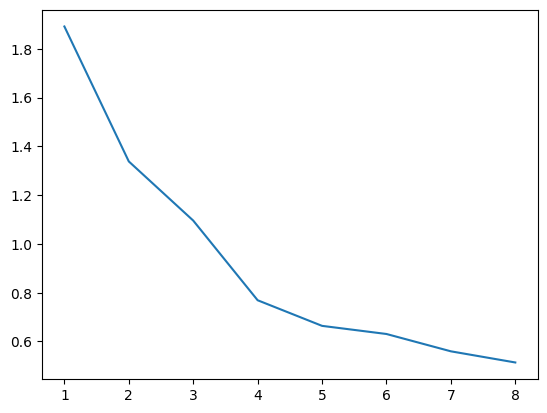

In [29]:
def calculate_NLL(X, kmax=10):
    nll = []
    for k in range(1, kmax+1):
        gmm = GaussianMixture(n_components = k) 
        gmm.fit(X)
        curr_nll = -gmm.score(X)
        print("k:", k, "NLL:", curr_nll)
        nll.append(curr_nll)
    return nll

nll = calculate_NLL(X_principal, kmax=8)

import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

x_plot = list(range(1, 9))
ax.plot(x_plot, nll)

En base al procedimiento anterior, se prosiguió con la creación del modelo Gaussiano Mixto. A este se le pasó como parámetro 4, para que se hagan 4 clusters de datos.

In [30]:
gmm = GaussianMixture(n_components = 4) 
gmm.fit(X_principal)

GaussianMixture(n_components=4)

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_11057/559753837.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(pos, nsig * width, nsig * height, angle)


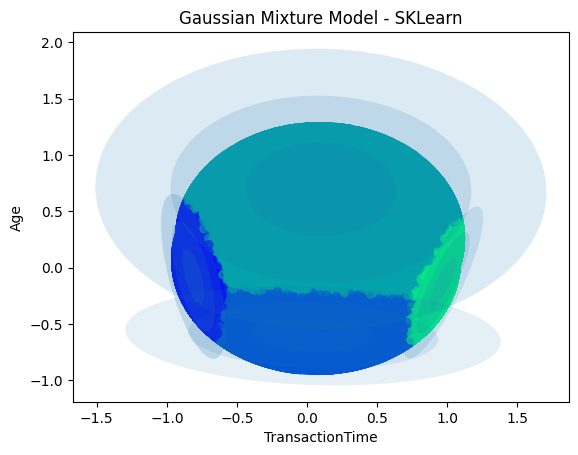

In [31]:
plt.scatter(X_principal['P1'], X_principal['P2'], c = GaussianMixture(n_components = 4).fit_predict(X_principal), cmap =plt.cm.winter, alpha = 0.6) 

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

# means, covarianzas y pesos del gmm
means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

w_factor = 0.2 / gmm.weights_.max()

for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    w2 = w * w_factor

    # Convert covariance to principal axes
    if covar.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covar)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covar)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ellipse = Ellipse(pos, nsig * width, nsig * height, angle)
        ellipse.set_alpha(w2)
        plt.gca().add_patch(ellipse)

plt.xlabel('TransactionTime')
plt.ylabel('Age')
plt.title('Gaussian Mixture Model - SKLearn')
plt.show()


En este caso, la métrica de Davis Bouldin Index indica qué tan bien se crearon los clusters del respectivo modelo. Mientras más cercano a 0 esté el valor, mejor. En este caso se obtuvo 0.74. 

Esto es bueno, ya que mientras más bajo es este valor, mejor es la separación entre los clusters. Cabe destacar que el valor máximo promedio de este índice es 3 a 4 (pero podría llegar hasta el infinito positivo), por lo cual este valor cercano a 0 es casi que bueno.

Finalmente, cabe destacar que con SKLearn se logró obtener un mejor resultado. Esto ya que se obtuvo un índice de 0.74 mientras que con el algoritmo manual se obtuvo 0.87 (ambos modelos usaron 4 clusters). Como se mencionó anteriormente, mientras más bajo el índice, mejor. 

In [32]:
# Davis Bouldin Index
print("Davis Bouldin Index:", metrics.davies_bouldin_score(X_principal, GaussianMixture(n_components = 4).fit_predict(X_principal)))

Davis Bouldin Index: 0.7406300111443713
